<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/Higgs_Boson_Classification_QMAML%20v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. Download and unzip the Higgs dataset
!wget -O HIGGS.csv.gz https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

--2025-06-11 12:07:40--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz            [    <=>             ]   2.62G  9.58MB/s    in 3m 44s  

2025-06-11 12:11:25 (12.0 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858]



In [3]:
!gunzip HIGGS.csv.gz

In [4]:
# Install PennyLane and XGBoost if not already installed
!pip install pennylane xgboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 57.2 MB/s eta 0:00:00


In [5]:
# 2. Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import pennylane as qml
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [16]:
CSV_PATH = 'HIGGS.csv'
N_TRAIN = 300_000         # More training data
N_META_TEST = 60_000      # More meta-test data
N_FEATURES = 40           # If using physics features
N_CLASSES = 2

# PQC/QNN
N_QUBITS = 16              # More qubits
PQC_LAYERS = 4            # Deeper PQC

# Classical meta-initializer (MLP for PQC params)
META_INIT_HIDDEN = 128    # Wider meta-initializer

# PQC-to-MLP mapping
PQC_TO_MLP_HIDDEN = 256   # Wider mapping MLP

# Meta-learner (PhysicsMLP)
HIDDEN_SIZE = 1024        # Wider MLP
N_LAYERS = 6              # Deeper MLP
DROPOUT = 0.4             # More regularization

# Meta-learning
META_TRAIN_TASKS = 50     # More meta-tasks per epoch
META_TEST_TASKS = 10      # More meta-test tasks
META_INNER_STEPS = 10     # More inner-loop steps
META_INNER_LR = 0.03      # Slightly lower for stability
META_OUTER_LR = 0.0003    # Lower outer-loop LR for stability
META_SUPPORT = 512        # Larger support set
META_QUERY = 2048         # Larger query set
N_EPOCHS = 10             # More meta-training epochs

In [17]:
class HiggsDataset(Dataset):
    def __init__(self, csv_path, n_samples=None, offset=0, add_physics_features=True):
        df = pd.read_csv(csv_path, header=None, nrows=n_samples, skiprows=range(1, offset+1))
        X = df.iloc[:, 1:].values.astype(np.float32)
        if add_physics_features:
            X = np.concatenate([
                X,
                np.log1p(np.abs(X[:, :5])),
                np.sqrt(np.abs(X[:, :5])),
                X[:, [0]] * X[:, [1]],
                X[:, [2]] / (X[:, [3]] + 1e-6)
            ], axis=1)
        self.X = X
        self.y = df.iloc[:, 0].values.astype(np.int64)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), self.y[idx]

In [18]:
# 5. PQC (QNN) and classical meta-initializer

# Quantum device
dev = qml.device("default.qubit", wires=N_QUBITS)

def angle_encode(x):
    for i in range(N_QUBITS):
        qml.RY(x[i], wires=i)

@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def pqc_circuit(weights, x):
    angle_encode(x)
    for l in range(weights.shape[0]):
        for i in range(N_QUBITS):
            qml.RY(weights[l, i, 0], wires=i)
            qml.RZ(weights[l, i, 1], wires=i)
        for i in range(N_QUBITS - 1):
            qml.CNOT(wires=[i, i + 1])
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

class PQCMetaInitializer(nn.Module):
    """Classical MLP to output PQC parameters from a task embedding."""
    def __init__(self, emb_dim, pqc_layers, n_qubits):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, META_INIT_HIDDEN),
            nn.ReLU(),
            nn.Linear(META_INIT_HIDDEN, pqc_layers * n_qubits * 2)
        )
        self.pqc_layers = pqc_layers
        self.n_qubits = n_qubits
    def forward(self, emb):
        out = self.mlp(emb)
        return out.view(self.pqc_layers, self.n_qubits, 2)

In [19]:
# 6. Task embedding and PhysicsMLP
def task_embedding(task):
    emb = torch.zeros(N_QUBITS)
    emb[:len(task['classes'])] = torch.tensor(task['classes']).float() / 10.0
    emb[-1] = torch.rand(1)
    return emb

class PhysicsMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=2, n_layers=4, activation='gelu', dropout=0.3):
        super().__init__()
        act = {
            'leakyrelu': nn.LeakyReLU(),
            'elu': nn.ELU(),
            'gelu': nn.GELU(),
            'silu': nn.SiLU()
        }[activation]
        layers = [nn.BatchNorm1d(input_dim)]
        for i in range(n_layers):
            layers.append(nn.Linear(input_dim if i == 0 else hidden_dim, hidden_dim))
            layers.append(act)
            layers.append(nn.LayerNorm(hidden_dim))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

In [20]:
# 7. Prepare meta-tasks (few-shot tasks)
def prepare_meta_tasks(dataset, n_tasks, n_way, k_shot, k_query):
    labels = np.array(dataset.y)
    classes_all = np.unique(labels)
    tasks = []
    for _ in range(n_tasks):
        classes = np.random.choice(classes_all, n_way, replace=False)
        support_x, support_y, query_x, query_y = [], [], [], []
        for i, c in enumerate(classes):
            idx = np.where(labels == c)[0]
            if len(idx) < k_shot + k_query:
                continue
            perm = np.random.permutation(idx)
            support_idx = perm[:k_shot]
            query_idx = perm[k_shot:k_shot + k_query]
            support_x.append(dataset.X[support_idx])
            support_y.append(np.full((k_shot,), i))
            query_x.append(dataset.X[query_idx])
            query_y.append(np.full((k_query,), i))
        if len(support_x) < n_way:
            continue
        support_x = np.concatenate(support_x)
        support_y = np.concatenate(support_y)
        query_x = np.concatenate(query_x)
        query_y = np.concatenate(query_y)
        tasks.append({
            'support_x': torch.tensor(support_x, dtype=torch.float32),
            'support_y': torch.tensor(support_y, dtype=torch.long),
            'query_x': torch.tensor(query_x, dtype=torch.float32),
            'query_y': torch.tensor(query_y, dtype=torch.long),
            'classes': classes
        })
    return tasks

In [21]:
# 8. QMAML meta-training and adaptation
def qmaml_meta_train(meta_tasks, pqc_meta_init, pqc_layers, n_qubits, n_epochs, n_inner, lr_inner, lr_outer, device):
    pqc_meta_init = pqc_meta_init.to(device)
    meta_opt = optim.Adam(pqc_meta_init.parameters(), lr=lr_outer)
    history = {'train_loss': [], 'train_acc': [], 'train_f1': [], 'train_roc': []}

    for epoch in range(n_epochs):
        total_loss = 0
        all_preds, all_trues, all_probs = [], [], []
        for task in meta_tasks:
            emb = task_embedding(task).to(device)
            pqc_params = pqc_meta_init(emb)
            # PQC output as meta-initialization for PhysicsMLP
            pqc_out = torch.tensor(pqc_circuit(pqc_params, emb)).float().detach()
            # Use PQC output to initialize PhysicsMLP weights (simple: add to initial weights)
            model = PhysicsMLP(N_FEATURES, HIDDEN_SIZE, N_CLASSES, n_layers=N_LAYERS, dropout=DROPOUT).to(device)
            with torch.no_grad():
                for p in model.parameters():
                    p.add_(0.01 * pqc_out.mean().item())
            # Inner loop adaptation
            optimizer = optim.SGD(model.parameters(), lr=lr_inner)
            for _ in range(n_inner):
                optimizer.zero_grad()
                logits = model(task['support_x'].to(device))
                loss = nn.CrossEntropyLoss()(logits, task['support_y'].to(device))
                loss.backward()
                optimizer.step()
            # Evaluate on query set
            logits_q = model(task['query_x'].to(device))
            loss_q = nn.CrossEntropyLoss()(logits_q, task['query_y'].to(device))
            total_loss += loss_q.item()
            preds = torch.argmax(logits_q, dim=1).cpu().numpy()
            trues = task['query_y'].cpu().numpy()
            probs = torch.softmax(logits_q, dim=1)[:, 1].detach().cpu().numpy()
            all_preds.extend(preds)
            all_trues.extend(trues)
            all_probs.extend(probs)
        # Meta-update
        meta_opt.zero_grad()
        torch.tensor(total_loss, requires_grad=True).backward()
        meta_opt.step()
        # Metrics
        acc = accuracy_score(all_trues, all_preds)
        f1 = precision_recall_fscore_support(all_trues, all_preds, average='binary', zero_division=0)[2]
        roc = roc_auc_score(all_trues, all_probs)
        history['train_loss'].append(total_loss / len(meta_tasks))
        history['train_acc'].append(acc)
        history['train_f1'].append(f1)
        history['train_roc'].append(roc)
        print(f"Epoch {epoch+1}: Loss {total_loss/len(meta_tasks):.4f}, Acc {acc:.4f}, F1 {f1:.4f}, ROC {roc:.4f}")
    return pqc_meta_init, history

def qmaml_meta_adaptation(pqc_meta_init, meta_tasks, n_inner, lr_inner, device):
    accs, f1s, rocs = [], [], []
    for task in meta_tasks:
        emb = task_embedding(task).to(device)
        pqc_params = pqc_meta_init(emb)
        pqc_out = torch.tensor(pqc_circuit(pqc_params, emb)).float().detach()
        model = PhysicsMLP(N_FEATURES, HIDDEN_SIZE, N_CLASSES, n_layers=N_LAYERS, dropout=DROPOUT).to(device)
        with torch.no_grad():
            for p in model.parameters():
                p.add_(0.01 * pqc_out.mean().item())
        optimizer = optim.SGD(model.parameters(), lr=lr_inner)
        for _ in range(n_inner):
            optimizer.zero_grad()
            logits = model(task['support_x'].to(device))
            loss = nn.CrossEntropyLoss()(logits, task['support_y'].to(device))
            loss.backward()
            optimizer.step()
        logits_q = model(task['query_x'].to(device))
        preds = torch.argmax(logits_q, dim=1).cpu().numpy()
        trues = task['query_y'].cpu().numpy()
        probs = torch.softmax(logits_q, dim=1)[:, 1].detach().cpu().numpy()
        accs.append(accuracy_score(trues, preds))
        f1s.append(precision_recall_fscore_support(trues, preds, average='binary', zero_division=0)[2])
        rocs.append(roc_auc_score(trues, probs))
    print(f"Meta-test: Acc {np.mean(accs):.4f}, F1 {np.mean(f1s):.4f}, ROC {np.mean(rocs):.4f}")
    return accs, f1s, rocs

In [22]:
# 9. Plotting utilities
def plot_metrics(history, title="Meta-Training Metrics"):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(16, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train')
    plt.title('Meta-Train Loss')
    plt.legend()
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train')
    plt.title('Meta-Train Accuracy')
    plt.legend()
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['train_f1'], label='Train')
    plt.title('Meta-Train F1')
    plt.legend()
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['train_roc'], label='Train')
    plt.title('Meta-Train ROC-AUC')
    plt.legend()
    plt.suptitle(title)
    plt.show()

Using device: cuda
Loading data...
Preparing meta-tasks...
Initializing PQC meta-initializer...
Meta-training (QMAML)...
Epoch 1: Loss 0.7733, Acc 0.5138, F1 0.5159, ROC 0.5203
Epoch 2: Loss 0.7723, Acc 0.5157, F1 0.5142, ROC 0.5212
Epoch 3: Loss 0.7698, Acc 0.5175, F1 0.5184, ROC 0.5242
Epoch 4: Loss 0.7700, Acc 0.5180, F1 0.5168, ROC 0.5244
Epoch 5: Loss 0.7702, Acc 0.5173, F1 0.5175, ROC 0.5252
Epoch 6: Loss 0.7704, Acc 0.5176, F1 0.5166, ROC 0.5246
Epoch 7: Loss 0.7703, Acc 0.5200, F1 0.5197, ROC 0.5266
Epoch 8: Loss 0.7711, Acc 0.5175, F1 0.5168, ROC 0.5241
Epoch 9: Loss 0.7708, Acc 0.5175, F1 0.5173, ROC 0.5234
Epoch 10: Loss 0.7737, Acc 0.5151, F1 0.5149, ROC 0.5203


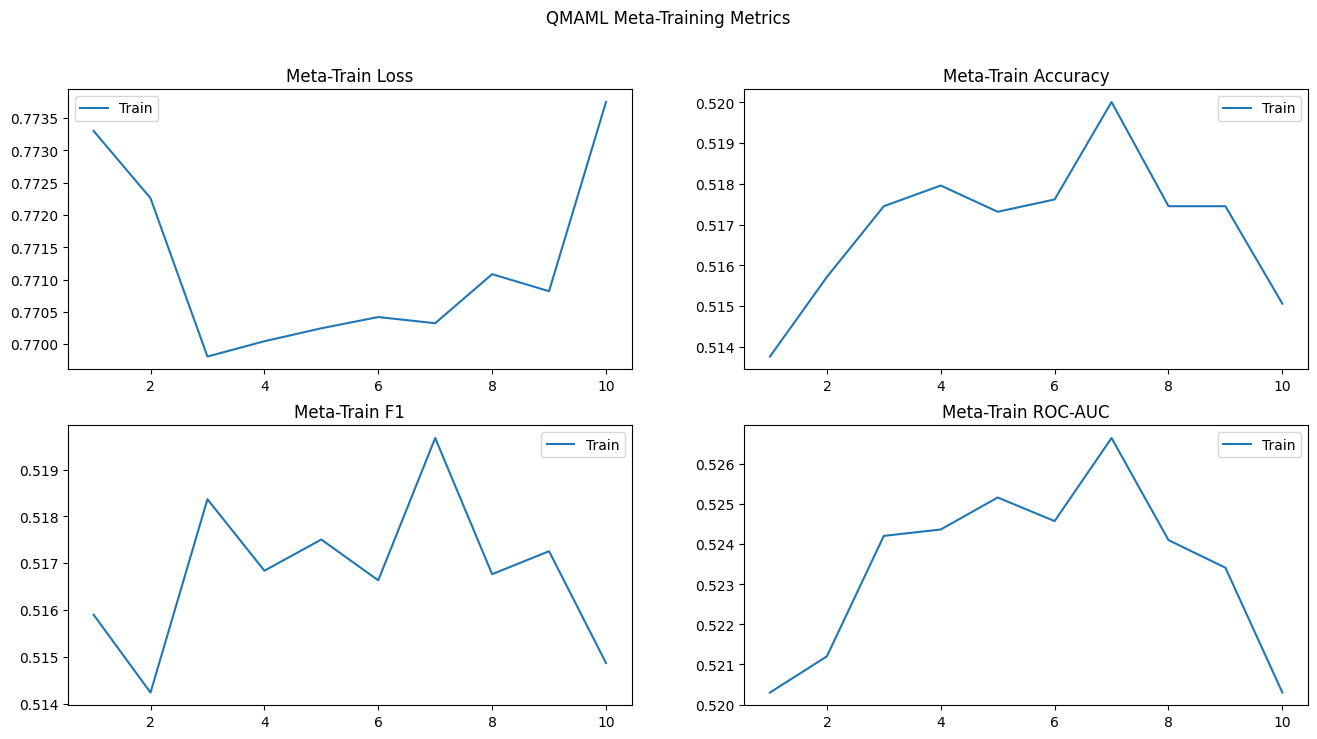

Meta-testing (adaptation)...
Meta-test: Acc 0.5157, F1 0.5156, ROC 0.5215


In [23]:
# 10. Run the QMAML pipeline
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    print("Loading data...")
    train_dataset = HiggsDataset(CSV_PATH, n_samples=N_TRAIN)
    test_dataset = HiggsDataset(CSV_PATH, n_samples=N_META_TEST, offset=N_TRAIN)
    print("Preparing meta-tasks...")
    meta_train_tasks = prepare_meta_tasks(train_dataset, META_TRAIN_TASKS, N_CLASSES, META_SUPPORT // N_CLASSES, META_QUERY // N_CLASSES)
    meta_test_tasks = prepare_meta_tasks(test_dataset, META_TEST_TASKS, N_CLASSES, META_SUPPORT // N_CLASSES, META_QUERY // N_CLASSES)
    print("Initializing PQC meta-initializer...")
    pqc_meta_init = PQCMetaInitializer(N_QUBITS, PQC_LAYERS, N_QUBITS)
    print("Meta-training (QMAML)...")
    pqc_meta_init, history = qmaml_meta_train(
        meta_train_tasks, pqc_meta_init, PQC_LAYERS, N_QUBITS, N_EPOCHS,
        META_INNER_STEPS, META_INNER_LR, META_OUTER_LR, device
    )
    plot_metrics(history, title="QMAML Meta-Training Metrics")
    print("Meta-testing (adaptation)...")
    qmaml_meta_adaptation(pqc_meta_init, meta_test_tasks, META_INNER_STEPS, META_INNER_LR, device)